# <div align="center"> Learning to play Blackjack with Q-learning </div>

In this notebook I will show how Q-learning can be used by an agent with no prior knowledge to teach itself to play Blackjack. I will then go on to compare its performance against a strategy recommended by a human expert, and hopefully show that the agent can consistently beat human performance.

My implementation is based on the following key sources, which I highly recommend reading through:
 - https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 
 - https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0 
 - https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-7-action-selection-strategies-for-exploration-d3a97b7cceaf 


#### Contents:
1. Overview of Blackjack environment 
2. Q-learning implementation and variations
3. Connect Q-learning algorithm with environment
4. Training for standard Q-learning
5. Training for Double Q-learning
6. Comparisons against human-strategy
7. Discussion


### 0) Load modules & basic set-up

In [6]:
import gym
from gym import spaces
from gym.utils import seeding

import pandas as pd
import numpy as np
import random
import datetime
import pickle
import os

import networkx as nx

from sklearn.model_selection import ParameterGrid

import matplotlib.pyplot as plt
import seaborn as sns

# hide warnings
import warnings
warnings.filterwarnings('ignore')

### 1) Overview of Blackjack environment

The basics of the environment are handled in local files *blackjack_env.py* and *settings.py*. The former is the main environment as hosted by openAI Gym, with some minor modifications to make the game more interesting. The latter contains some parameters I added which influence the laws of the game held in the main environment file, e.g. controlling when the dealer stops taking cards or how many different actions we allow our agent to perform.

In [24]:
# load settings of environment from local file
from settings import *

# load the Blackjack environment from local file
from blackjack_env import *

# create environment
env = BlackjackEnv()

# Confirm the environment our agent will play in
ENV_VALS = (BLACKJACK_SCORE, DEALER_STOP, DOUBLE_BIAS, ODDS_BOOST, NUM_ACTIONS)
print("Created environment:")
print("Goal: %i | DealerStop: %i | DoubleBias: %i | DoubleBoost: %i | NumActions: %i" % ENV_VALS)

Created environment:
Goal: 21 | DealerStop: 4 | DoubleBias: 0 | DoubleBoost: 2 | NumActions: 3


It is useful to articulate the environment's state transition matrix before going any further. This will help us understand the environment our agent needs to traverse in a more mathematical fashion, particularly the probabilities associated with drawing cards randomly.

As the actual calculation of the probabilities is not the focus of this notebook, I will only show how I calculated probabilities of initial hand values. The remaining state transition probabilities, e.g. as additional cards are taken, are loaded from a .csv I formed earlier. Our focus will rather be visualising the transitions. Since there are three different state dimensions and actions lead to stochastic results, it is convenient to visualise state transitions as a graph where transition probabilities are encoded via edge widths. We can use some numpy matrices and networkx to do this. 

First, let's calculate the probabilities of each initial hand value:

In [39]:
### Form probabilities of initial hand values
# form array of 2 x card values, then set joint probabilities (infinite decks)   
P = np.ones([10, 10]) * (1/13 * 1/13)   # 13 different cards, p(card) = 1/13

# cater for value of 10 being 4 times as likely (10, J, Q, K = 10 points)
# minus 2 because of zero index and no inclusion of 1
ten_idx = 10-2 
P[ten_idx, :] = (1/13 * 4/13)
P[:, ten_idx] = (1/13 * 4/13)
P[ten_idx, ten_idx] = (4/13 * 4/13)
assert(np.isclose(1.0, P.sum()))  # check probabilities sum to 1
    
# form hand values by adding together the value of the two cards
handVal = P.copy()
for i in np.arange(0,P.shape[0]):
    for j in np.arange(0, P.shape[1]):
        # first row denotes cards 2 and 2
        handVal[i,j] = (i+2) + (j+2)
        # if two aces we don't have 11 + 11 = 22, but 11 + 1 = 12
        if i == 11-2 & j == 11-2:
            handVal[i,j] = 12
        
# use the two above matrices to find probabilites of each value hand
valP = np.zeros(18)
for ix, v in enumerate(np.arange(4, 21+1)):
    for i in np.arange(0,P.shape[0]):
        for j in np.arange(0, P.shape[1]):
            if handVal[i,j]==v:
                valP[ix] += P[i,j]
assert(np.isclose(1.0, valP.sum()))  # check probabilities sum to 1

Now let's create networkx graph objects that map probability values held in matrices to edge widths. We will make two: one for the 'no usable ace' state and one for the 'usable ace' state.

In [25]:
### Form transition graph for taking extra cards ("hit",in "no usable Ace" state)
# load data and form a "from-a-to-b" probability matrix
df = pd.read_csv('additional_analysis/transMatrix_Hit.csv')
M = np.array(df)

# incorporate the initial hand probas into a graph
G = nx.MultiDiGraph(directed=True)
for ix, p in enumerate(valP):
    G.add_edges_from([(0, ix+4, {'weight':p})])
    
# loop through from-a-to-b matrix probabilities adding edges between nodes    
for f in np.arange(0, M.shape[0]):
    # note that index values are 1 below the actual value of the hand
    for t in np.arange(0, M.shape[1]):
        # add positive probability transitions to the graph
        if M[f,t] > 0:
            frm = f+4
            to = t+4
            G.add_edges_from([(frm, to, {'weight':M[f,t]})])
    assert(np.isclose(1.0, M[f,:].sum()))  # check probabilities sum to 1

In [32]:
### Form transition graph for taking extra cards ("hit",in "Usable Ace" state)
# load data and form a "from-a-to-b" probability matrix
dfA = pd.read_csv('additional_analysis/transMatrix_Hit_UseAce.csv')
MA = np.array(dfA)

G2 = nx.MultiDiGraph(directed=True)
G2.graph['edge'] = {'arrowsize': '0.6', 'splines': 'curved'}
for f in np.arange(0, MA.shape[0]):
    # note that index values are 1 below the actual value of the hand
    for t in np.arange(0, MA.shape[1]):
        # add positive probability transitions to the graph
        if MA[f,t] > 0:
            frm = f+4
            to = t+4
            # add selfloops as directed to fictional node "99"
            if frm == to:
                to = 99
            G2.add_edges_from([(frm, to, {'weight':MA[f,t]})])
    assert(np.isclose(1.0, M[f,:].sum()))  # check probabilities sum to 1

Now we can finally plot the graph objects. While we have shown the transitions as two separate "slices" of the overall transition matrix, we must remember that our agent can transition from the slice on the left to the slice on the right. This will happen when it picks up its first Ace, an event which occurs with probability 1/13.

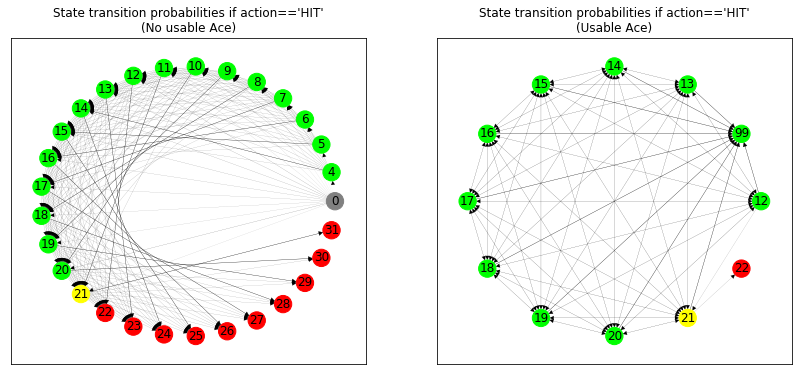

In [42]:
### Show graphs, removing surplus ink like axis ticks
f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6), squeeze=True)
for ax in [ax1, ax2]:
    ax.set_xticks([])
    ax.set_yticks([])
    
# graph 1: probabilties when no usable ace
ax1.set_title("State transition probabilities if action=='HIT'\n(No usable Ace)")
pos=nx.circular_layout(G)
colors = list(["gray"]) + list(["lime"] * 17) + list(["yellow"]) + list(["red"]*10)
nx.draw_networkx_nodes(G,pos=pos, node_color = colors, ax=ax1)       
edges = G.edges()
G.graph['edge'] = {'arrowsize': '0.6', 'splines': 'curved'}
weights = [G[u][v][0]['weight'] for u,v in edges]
nx.draw_networkx_edges(G,pos=pos, width=weights, ax=ax1)    
nx.draw_networkx_labels(G,pos=pos, ax=ax1)

# graph 2: probabilties when usable ace
ax2.set_title("State transition probabilities if action=='HIT'\n(Usable Ace)")
pos=nx.circular_layout(G2)
colors = list(["lime"] * 10) + list(["yellow"]) + list(["red"]*1)
nx.draw_networkx_nodes(G2,pos=pos, node_color = colors, ax=ax2)       
edges = G2.edges()
weights = [G2[u][v][0]['weight'] for u,v in edges]
nx.draw_networkx_edges(G2,pos=pos, width=weights, arrows=True, ax=ax2)    
nx.draw_networkx_labels(G2,pos=pos, ax=ax2)
plt.show()

Notes:
- Green = valid in-play states;   Yellow = goal state of 21;   Red = losing states.
- self-loops have been shown as nodes connecting to the "fictional" node 99

### 2) Q-learning implementation and variations

We will start by implementing a series of selection policies, all of which control how our agent chooses actions. Since the agent will start with a blank canvas, we cannot simply let the agent always pick the "best" action. Rather, these policies help the agent manage the "exploration-exploitation trade-off". In all cases, the agent will start by prioritising "exploration": choosing actions mostly randomly so that it can experience as many different rewards and penalties as possible. As it gains more experience, it will begin to reduce the frequency of these random actions, instead prioritising "exploitation": using its experience so far to choose the action with highest expected future rewards.

The policies implemented are:
- e-greedy policy
- boltzmann policy
- both of the above but with Double-Q learning (see more in the following block of code)

In [44]:
def select_egreedy(Q_row, number_actions, eps=0.9):
    """
    Select an action (index) based on e-greedy policy,
    e.g. random with probability e and per
    current Q-values with probability 1-e
    """
    if np.random.rand() < eps:
        # pick by random choice
        return np.random.choice(np.arange(0, number_actions))   
    else:
        # choose highest expected value action
        return np.argmax(Q_row)    

def select_boltzmann(Q_row, number_actions, tau=1):
    """
    Select an action (index) based on current Q values and
    the current state of annealing, e.g. using inverse
    temperature, tau.
    
    PARAMS:
    tau = inverse temperature, e.g. as tau approaches 0
          boltzmann distribution approaches uniform sampling.
          higher tau prefers actions with higher expected values
    """
    # normalize wrt minimum values, ensuring no negatives
    Q_row_ajd = Q_row - Q_row.min()

    # calculate probabilities under boltzmann distribution
    Q_pr = np.exp(tau * Q_row_ajd) / np.exp(tau * Q_row_ajd).sum()
    
    # Make selection (credit: Arthur Juliani's Medium article)
    action_value = np.random.choice(Q_pr, p=Q_pr)
    return np.argmax(Q_pr == action_value)

def select_a(Q_row, policy="e", param=0.9):
    """ Select action from a row of Q for the given state
    and for a given policy & parameter
    
    if policy == "e" then we will use e-greedy policy
    if policy == "b" then we will use boltzmann distribution
    """
    # choose action based on policy required
    if policy=="e":
        # use e-greedy policy, where param = epsilon
        return select_egreedy(Q_row, env.action_space.n, param)
    else:
        # use boltzmann policy, where param = tau = inverse temperature
        return select_boltzmann(Q_row, env.action_space.n, param)
    
def doubleQ_select(Q_a, Q_b, s, policy="e", policy_param = 0.9):
    """
    Function which enables selection using two Q matrices. Per van Hasselt's
    original implementation:
       'In our experiments, we calculated the average of the two Q values for each
    action and then performed e-greedy exploration with the resulting average
    Q values.' (Hado van Hasselt)
    
    Optional params:
        policy = "e" or "b" for e-greedy and boltzmann respectively
        policy_param = float, epsilon if e-greedy or inverse temperature (tau)
                       if boltzmann 
    """
    
    # take average Q values under consideration for given state
    Q_avg_row =  (Q_a[s] + Q_b[s])/2
    
    # choose action based on given policy and policy parameter
    return select_a(Q_avg_row, policy, policy_param)

We now move to defining our update rules, which is how the agent learns from experience in playing Blackjack. We will use the standard update rule as well as a variation called **Double Q learning**, where two matrixes are maintained to avoid over-estimation of expected returns. For more information on this variation see https://arxiv.org/abs/1509.06461 

In [45]:
def vanillaQ_update(Q, r, s, s1, a, lr, y):
    """
    Update Q-matrix using standard update rule
    """
    Q[s][a] = Q[s][a] + lr*(r + y*np.max(Q[s1]) - Q[s][a])
    return Q

def doubleQ_update(Q_a, Q_b, r, s0, s1, a,
                   lr, y, prob_update_Q_a = 0.5):
    """
    Randomly select a Q matrix to update, estimating future
    rewards from the other matrix. Per van Hasselt's original
    implementation.
    
    Parameters:
        - prob_update_Q_a: probability of updating the first matrix.
                           (allows experimentation with reliance on
                           the first Q matrix vs the second Q matrix)
    """
    
    if np.random.rand() < prob_update_Q_a:
        # update Q_a matrix, taking copy before update for reference
        Q_old = np.copy(Q_a)
        optimal_a = np.argmax(Q_a[s1][a])
        Q_a[s0][a] = Q_a[s0][a] + lr*(r + y*Q_b[s1][optimal_a] - Q_a[s0][a])
        
    else:
        # update Q_b matrix, taking copy before update for reference
        Q_old = np.copy(Q_b)
        optimal_b = np.argmax(Q_b[s1][a])
        Q_b[s0][a] = Q_b[s0][a] + lr*(r + y*Q_a[s1][optimal_b] - Q_b[s0][a])
        
    return Q_a, Q_b, Q_old

### 3) Connect Q-learning algorithm with environment

Now that we have an environment and functions that implement Q-learning, we can connect them together and watch our agent learn to play! We will put this functionality into a function so that we can easily recall it under different parameters in the rest of this notebook. 

In [46]:
def playGame(Q_a=None, Q_b = None, verbose=0,
             dbl_Q=0, lr=0.1, y=0.6,
             policy = "e", policy_param=0.7,
             num_episodes = 1, cb_over_num_eps=10000):
    """
    Main function where agent learns to play Blackjack.
    
    Inputs:
      Q_a, Q_b        = None, None or pre-trained matrix, None
      verbose         = verbosity level
      dbl_Q           = 1 if using double Q learning
      policy          = "e" for e-greedy, "b" for boltzmann
      policy_param    = float controlling above policy
      num_episodes    = number of games to play
      cb_over_num_eps = maintain a callback version of agent 
                        if they have superior performance over
                        this number of games
                        
    Outputs:
      Q_out           = Q-matrix of agent after final episode
      rList           = list of agent's rewards in each episode 
      Q_cb            = Q-matrix of callback agent
      last_cb_ep      = episode number where callback agent was created
    """
    
    # state space needs to be blackjack_score+11
    # e.g. ace on top of a score of 21
    if Q_a is None:
        Q_a = np.zeros([BLACKJACK_SCORE+11,11,2,env.action_space.n])

    # take a copy of Q matrix if we are using double Q learning
    if dbl_Q != 0:
        Q_b = np.copy(Q_a)
    
    # prepare a 'call-back' version of the Q-matrix
    # e.g. the one with best mean rewards over last N episodes
    Q_cb = Q_a.copy()
    best_meanR = -999999    # value holding "best score" yet
    last_cb_ep = 0          # record of last episode the call-back is made to
    a_freq = np.zeros(env.action_space.n)

    # if using Boltzmann policy, set rate of annealing (tau = inverse temperature)
    if policy=="b":
        tau_growth = (200/policy_param)**(1/num_episodes)

    #create lists to contain total rewards and steps per episode
    rList = []
    aList = []
    
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        
        # game will not exceed 20 moves, limit while loop out of caution
        while j < 20:
            j+=1

            # choose an acion per given policy        
            if dbl_Q==0:
                Q_row = Q_a[s]
                a = select_a(Q_row, policy, policy_param)  
            else:
                Q_avg_row =  (Q_a[s] + Q_b[s])/2
                a = select_a(Q_avg_row, policy, policy_param) 
                
            # log the actions chosen
            a_freq[a] += 1
            aList.append(a)

            #Get new state and reward from environment
            Q_old = np.copy(Q_a)
            player_hand_old = env.player.copy()
            s1,r,d,_ = env.step(a)
            
            #U pdate Q-Table with new knowledge, unless in testing mode (lrate = 0.0)
            if lr > 0:
                if dbl_Q==0:
                    Q_a[s][a] = Q_a[s][a] + lr*(r + y*np.max(Q_a[s1]) - Q_a[s][a])
                else:
                    # Double-Q learning: use the second matrix as estimate of expected returns
                    Q_a, Q_b, Q_old = doubleQ_update(Q_a, Q_b, r, s, s1, a, lr, y)
    
            # inspect the step & Q matrix once, at 1/5 through training
            if (i == num_episodes//5) & (verbose > 2):
                if ((dbl_Q==0)|(np.array_equal(Q_b, Q_old))):
                    Q_new = np.copy(Q_a)
                else:
                    Q_new = np.copy(Q_b) 
                show_step(player_hand_old, env.player, env.dealer,
                          s, s1, a, Q_old, Q_new, r, d)
            
            # update rewards and state
            rAll += r
            s = s1

            if d == True:            
                #Reduce chance of random action as we train the model.
                # for e-greedy policy, reduce epsilon
                if policy=="e":
                    if policy_param >= 0.5:
                        policy_param *= 0.99999
                    else:
                        policy_param *= 0.9999
                        
                # for boltzmann policy, increase tau (inverse temperature)
                if policy=="b":
                    policy_param *= tau_growth
                
                # For each of the final 5 episodes, show the game for inspection
                if (i >= (num_episodes-5)) & (verbose > 1):
                    show_ep(env.player, env.dealer, r, i)
                
                break

        # append reward to list
        rList.append(rAll)
        
        # update the callback Q-matrix IIF better average over last N episodes
        meanR_lastN_eps = meanR_lastN(rList, n=cb_over_num_eps)
        if ((i > cb_over_num_eps) & (meanR_lastN_eps > best_meanR)):
            
            # take average of Q-values first if double Q learning
            if dbl_Q == 0:
                Q_cb = np.copy(Q_a)
            else:
                Q_cb = (Q_a + Q_b) / 2
            last_cb_ep = i
            best_meanR = meanR_lastN_eps
            
        # show some training feedback every n episodes
        feedback_freq = 25000
        if verbose > 0:
            if i % feedback_freq == 0:
                print("Ep: {}\tMean reward over last {} episodes: {}. ({}-policy @ {})".format(i,
                        cb_over_num_eps, meanR_lastN_eps,
                        policy, np.around(policy_param, decimals=5)))
        
    # show overall success history of agent 
    if verbose > 1:
        plt.figure(figsize=(12,4))
        plt.plot(np.cumsum(rList))
        plt.title('Performance vs. episodes')
        plt.ylabel('Total Returns')
        plt.xlabel('Episode number')
        plt.axvline(x=last_cb_ep, linestyle="--", color="black")    # show the last callback episode
        plt.show()
        
        pc_actions_taken = a_freq/a_freq.sum()
        print(pc_actions_taken)
        
    # before returning Q matrix, take average if double Q-learning
    if dbl_Q == 0:
        Q_out = np.copy(Q_a)
    else:
        Q_out = (Q_a + Q_b)/2
        
    return Q_out, rList, Q_cb, last_cb_ep

### 4) Training for standard Q-learning

Before we start training, we want to have some functions that let us evaluate the agent's performance numerically, as well as some ability to visually inspect what is going on at both a high- and granular-level.

In [47]:
def mode(l):
    """ Find the mode of a given list l. """
    return max(set(l), key=l.count)

def meanR_lastN(r_list, n=200):
    """ Find mean over the last n items in a list """
    return np.mean(r_list[-n:])

def action_dict(a, short=False):
    if short:
        lookup = {0: "St", 1: "Hi", 2: "Db", 3: "Su", 4: "In"}
    else:
        lookup = {0: "Stick", 1: "Hit", 2: "Double", 3: "Surrender", 4: "Invest"}
    return lookup[a]

def convert_first_1_to_11(l):
    """ Convert the first 1 in a hand to 11, e.g. to faciliate understanding of hands played involving an Ace """
    for idx, i in enumerate(l):
        if i == 1:
            l[idx] = 11
            break
    return l

In [48]:
def show_ep(player_hand, dealer_hand, reward, ep_no, cumulative=True):
    """ Summarise the episode in text once it is complete """
    
    # set some placeholder strings to indicate who won/lost/drew
    pl_bust = ""
    dl_bust = ""
    
    # show if anyone went bust with XXX
    if is_bust(player_hand):
        pl_bust = "XXX"
    if is_bust(dealer_hand):
        dl_bust = "XXX"
    
    # show who won, using !!! for win and --- for draw
    if reward > 0:
        pl_win = "!!!"
        dl_win = ""
    elif reward < 0:
        pl_win = ""
        dl_win = "!!!"
    else:
        pl_win = "---"
        dl_win = "---"
        
    # update hands to show effects of an Ace being used as 11 (instead of 1)
    if usable_ace(player_hand):
        player_hand = convert_first_1_to_11(player_hand)
    if usable_ace(dealer_hand):
        dealer_hand = convert_first_1_to_11(dealer_hand)
        
    # display results
    print("--- SUMMARY OF EP #{} ---".format(ep_no))
    if cumulative:
        # simplest view
        print("Player:\t{} {}{}".format(np.cumsum(player_hand), pl_bust, pl_win))
        print("Dealer:\t{} {}{}".format(np.cumsum(dealer_hand), dl_bust, dl_win))
        print(player_hand)
        print(dealer_hand)
    else:
        # more detailed view, showing progression of cards from initial (visible) hands to final hands
        print("Player:\t{} >> {} >> {} {}{}".format(player_hand[:2], player_hand, sum_hand(player_hand),
                                                    pl_bust, pl_win))
        print("Dealer:\t{} >> {} >> {} {}{}".format(dealer_hand[:1], dealer_hand, sum_hand(dealer_hand),
                                                    dl_bust, dl_win))

def show_step(player_hand_old, player_hand_new, dealer_hand,
              s0, s1, a, Q0, Q1, r, d):
    """ Give a detailed view of each step in a hand """
    # current state summary and action
    print("""-----------------------
Player's old hand:\t{} (={})
Dealer's face-up card:\t{}
Player had useable:\t{}
Player action:\t\t{} ({})""".format(player_hand_old, s0[0], s0[1], s0[2], a, action_dict(a)))
    
    # effects of action
    if player_hand_old != player_hand_new:
        print("""Player got card:\t{}""".format(player_hand_new[-1]))
        
    # Dealer's eventual outcome
    print("Dealer's hand:\t{} (={})".format(dealer_hand, sum_hand(dealer_hand)))
    print("{}\n{}".format(s0, s1))
    
    print("r:{} | Done: {}".format(r, d))
    
    # show two Q matrices separately
    inspect_Q(Q0)
    inspect_Q(Q1)
    
    # show the difference
    Q_diff = Q1 - Q0
    inspect_Q(Q_diff)

def inspect_Q(Q_in):
    """ Inspect the Q matrix as heatmaps
    Split out each action's Q-values for all possible states"""
        
    # Heatmaps: Show side-by-side action Q-matrix, with two rows for each Usable Ace state
    color_limits = np.max([abs(np.min(Q_in)), np.max(Q_in)])
    i_labels = ['No useable ace', 'Useable ace']
    j_labels = ['Stick', 'Hit', 'Double', 'Surrender', 'Invest'][:NUM_ACTIONS]
    
    # new row of plots for each of the binary states Ace / no Ace
    for i in np.arange(0, len(i_labels)):    
        plt.figure()
        f, axes = plt.subplots(1,len(j_labels), sharex=False, sharey=False,
                                          figsize=(12,6))
        plt.title(i_labels[i])
        # show Q values for each possible action, across all hand values x initial dealer card
        for j in np.arange(0, len(j_labels)):
            # show each heat map, adding color bar for the last plot only
            showCbar = j == len(j_labels)-1
            # obtain the relevant Q values - hiding non-used states (4- & 22+ for player / 0 for dealer)
            g = sns.heatmap(Q_in[4:22,1:,i,j], cmap='seismic_r', cbar=showCbar,
                            vmin = -color_limits, vmax = color_limits, center=0, ax=axes[j])
            g.set_title("{}\n - {} - ".format(j_labels[j], i_labels[i]))
            g.set_xlabel('Dealer initial card')
            # set agent hand value range of 4-21 inclusive, dealer 2-11 inclusive
            g.set_yticklabels(np.arange(4,22), rotation=0)
            g.set_xticklabels(np.arange(1,11), rotation=0)  # where Ace = 1 for now
            # only show y label on first plot
            if j == 0:
                g.set_ylabel('Agent hand value')
                
        plt.show()

We are almost ready to start training. All we have to do first is choose how long we want to train the agent for, how many games we are going to evaluate it over, and of course some hyper-parameter values. We will start with some which seem sensible, and move onto more robust experimentation in following sections.

For this section, we will use the Boltzmann selection policy to ensure the code works as intended.

In [49]:
### Set scope of training and evaluation
# number of episodes to train agent over
NUM_EPISODES_TRAIN = 250000                

# evaluate agent with mean rewards over last (N) episodes
EVAL_LAST_N_EPS = 50000                     

# number of episodes to test agent over per round (learning OFF)
NUM_TO_TEST = int(EVAL_LAST_N_EPS / 50)    

# number of rounds N (each of Z episodes) to test agent(s) over
NUM_TEST_ROUNDS = 1000                     

### Set verbosity level
# 0: nothing
# 1: validation metrics only
# 2: validation, perf-vs-episodes, last 5 games
# 3: inspect Q-matrix update 1/5 of way into training
VERBOSE =2

In [50]:
# Set hyper-parameters: grid format will be beneficial when we optimize these 
grid = ParameterGrid({"dbl_Q" : [0],                # 1 to use Double Q learning
                          "lr": [0.01],             # learning rate
                          "y": [0.3],               # gamma
                          "policy": "b",            # "e" for e-greedy, "b" for boltzmann
                          "policy_param":  [1],     # epsilon / tau (inverse temperature)
                          "num_episodes": [NUM_EPISODES_TRAIN],
                          "cb_over_num_eps": [EVAL_LAST_N_EPS],
                          "verbose": [VERBOSE]})

Finally, we can start training an agent in the next block.

In [ ]:
# set up evaluation metric arrays
eval_metrics = []

# iterate through the grid search    
grid_size = len(grid)
for p_idx, params in enumerate(grid):
    agent_summary = (params['dbl_Q'], params['lr'], params['y'],
                     params['policy'], params['policy_param'])
    print("---------------------------\nNow training agent {}/{}".format(p_idx+1, grid_size))
    print("DblQ freq: %.2f | LR: %.3f | g: %.3f | pol: %s | pol_param: %.5f" % agent_summary)

    # train agent using current parameters
    Q, rList, Q_CB, lastCB_ep = playGame(Q_a=None, Q_b=None, **params)

    # calculate evaluation metrics
    eval_final = meanR_lastN(rList, n=EVAL_LAST_N_EPS)
    eval_cb = meanR_lastN(rList[:lastCB_ep], n=EVAL_LAST_N_EPS)

    if VERBOSE>0:
        print("---------------------------\nValidation metrics\n---------------------------")
        print("After final episode, mean reward of {} over last {} episodes".format(eval_final, EVAL_LAST_N_EPS))
        print("After episode {}, mean reward of {} over last {} episodes".format(lastCB_ep, eval_cb, EVAL_LAST_N_EPS))

    # Pickle Q matrices for later user
    exportMe = False
    if exportMe:
        print("---------------------------\nPickling agents")
        export_name = 'Qmatrix_expID_{}_Fi_DblQ{}_lr{}_g{}_pol{}_polparam{}.p'.format(p_idx, params['dbl_Q'], params['lr'],
                                                                    params['y'], params['policy'], params['policy_param'])
        name_fi = Q_DATA_DIR + export_name
        pickle.dump(Q , open(name_fi, "wb" ) )

        # Pickle the call back too, referencing the call-back episode in filename
        export_name_cb = 'Qmatrix_expID_{}_CB{}_DblQ{}_lr{}_g{}_pol{}_polparam{}.p'.format(p_idx, lastCB_ep,
                                                                                  params['dbl_Q'], params['lr'],
                                                                                  params['y'], params['policy'], params['policy_param'])
        name_cb = Q_DATA_DIR + export_name_cb 
        pickle.dump(Q_CB, open(name_cb, "wb" ) )

        # pickle the rLists using for later analysis (same filenames but different folder)
        pickle.dump(rList , open(RLIST_DATA_DIR + export_name, "wb" ) )
        pickle.dump(rList[:lastCB_ep], open(RLIST_DATA_DIR + export_name_cb, "wb" ) )

        # form Vector of validation metrics, for both final agent and call-back agent
        eval_vec_fi = [name_fi, params['dbl_Q'], params['lr'], params['y'], params['policy'], params['policy_param'],
                       params['num_episodes'], params['cb_over_num_eps'], 0, eval_final]
        eval_vec_cb = [name_cb, params['dbl_Q'], params['lr'], params['y'], params['policy'], params['policy_param'],
                       params['num_episodes'], params['cb_over_num_eps'], lastCB_ep, eval_cb]
        eval_metrics.append(eval_vec_fi)
        eval_metrics.append(eval_vec_cb)

---------------------------
Now training agent 1/1
DblQ freq: 0.00 | LR: 0.010 | g: 0.300 | pol: b | pol_param: 1.00000
Ep: 0	Mean reward over last 50000 episodes: -1.0. (b-policy @ 1.00002)


### 5) Training for Double Q-learning

We will now train another agent using Double Q-learning. This time we will use the e-greedy selection policy, instead of the boltzmann one. We will return to more robust optimization using a grid search once we have tested the code here.

In [ ]:
# Set hyper-parameters: grid format will be beneficial when we optimize these 
grid = ParameterGrid({"dbl_Q" : [1],                # 1 to use Double Q learning
                          "lr": [0.01],             # learning rate
                          "y": [0.3],               # gamma
                          "policy": "e",            # "e" for e-greedy, "b" for boltzmann
                          "policy_param":  [0.99],     # epsilon / tau (inverse temperature)
                          "num_episodes": [NUM_EPISODES_TRAIN],
                          "cb_over_num_eps": [EVAL_LAST_N_EPS],
                          "verbose": [VERBOSE]})